In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
import os


In [18]:
# 完整的日语平假名映射（包括清音、浊音、半浊音、拗音等）
hiragana_list = [
    # 清音
    'あ', 'い', 'う', 'え', 'お',
    'か', 'き', 'く', 'け', 'こ',
    'が', 'ぎ', 'ぐ', 'げ', 'ご',
    'さ', 'し', 'す', 'せ', 'そ',
    'ざ', 'じ', 'ず', 'ぜ', 'ぞ',
    'た', 'ち', 'つ', 'て', 'と',
    'だ', 'ぢ', 'づ', 'で', 'ど',
    'な', 'に', 'ぬ', 'ね', 'の',
    'は', 'ひ', 'ふ', 'へ', 'ほ',
    'ば', 'び', 'ぶ', 'べ', 'ぼ',
    'ぱ', 'ぴ', 'ぷ', 'ぺ', 'ぽ',
    'ま', 'み', 'む', 'め', 'も',
    'や', 'ゆ', 'よ',
    'ら', 'り', 'る', 'れ', 'ろ',
    'わ', 'を', 'ん',
    # 拗音（きゃ、しゃ、ちゃ等）
    'ゃ', 'ゅ', 'ょ',
]

# 创建平假名到整数的映射
hiragana_map = {char: i+1 for i, char in enumerate(hiragana_list)}


hiragana_map["."]=0
hiragana_map["Male"]=75
hiragana_map["Female"]=76
hiragana_map["padding"]=77
hiragana_index_map = {i:char for char, i in hiragana_map.items()}
print(f"总共 {len(hiragana_map)} 个字符")
print(f"映射范围: 0-{len(hiragana_map)-1}")



总共 78 个字符
映射范围: 0-77


In [19]:
train_df=pd.read_csv("data/gendec-train.csv", encoding='utf-8')
input_df=train_df[["Gender","Hiragana"]]
padding_length=20
min_len=3
tmp=[]
for i in range(len(input_df)):
    tmp.append([0,hiragana_map.get(input_df.iloc[i]['Gender'], 0)]+[hiragana_map.get(char, 0) for char in input_df.iloc[i]['Hiragana']]+[0])

transinput=[]
for i in range(len(input_df)):
    ix=tmp[i][:-1]
    if len(ix)>padding_length:
        ix=ix[-padding_length:]
    iy=tmp[i][1:]
    transinput.append([ix, iy])

transinput[:20]

[[[0, 75, 26, 56, 2, 6, 23, 63, 17], [75, 26, 56, 2, 6, 23, 63, 17, 0]],
 [[0, 75, 26, 7, 60, 30, 1, 7, 42, 30], [75, 26, 7, 60, 30, 1, 7, 42, 30, 0]],
 [[0, 75, 1, 6, 2, 17, 6, 28, 61], [75, 1, 6, 2, 17, 6, 28, 61, 0]],
 [[0, 75, 40, 56, 9, 2, 18, 9], [75, 40, 56, 9, 2, 18, 9, 0]],
 [[0, 75, 7, 8, 26, 56, 16, 42, 68], [75, 7, 8, 26, 56, 16, 42, 68, 0]],
 [[0, 76, 2, 69, 56, 16, 30, 10], [76, 2, 69, 56, 16, 30, 10, 0]],
 [[0, 76, 1, 7, 61, 56, 16, 36, 4], [76, 1, 7, 61, 56, 16, 36, 4, 0]],
 [[0, 75, 40, 19, 56, 16, 42, 68], [75, 40, 19, 56, 16, 42, 68, 0]],
 [[0, 75, 42, 64, 2, 69, 6, 23, 62, 7], [75, 42, 64, 2, 69, 6, 23, 62, 7, 0]],
 [[0, 76, 17, 64, 7, 62, 6], [76, 17, 64, 7, 62, 6, 0]],
 [[0, 76, 3, 18, 31, 1, 7, 10], [76, 3, 18, 31, 1, 7, 10, 0]],
 [[0, 76, 43, 22, 69, 64, 16, 28, 7], [76, 43, 22, 69, 64, 16, 28, 7, 0]],
 [[0, 75, 15, 3, 31, 17, 14, 1, 7], [75, 15, 3, 31, 17, 14, 1, 7, 0]],
 [[0, 75, 60, 65, 2, 10, 3, 18, 9], [75, 60, 65, 2, 10, 3, 18, 9, 0]],
 [[0, 75, 62, 60, 30

In [20]:
# 加载测试集
test_df = pd.read_csv("data/gendec-test.csv", encoding='utf-8')
test_input_df = test_df[["Gender","Hiragana"]]
test_tmp = []
for i in range(len(test_input_df)):
    test_tmp.append([0, hiragana_map.get(test_input_df.iloc[i]['Gender'], 0)] + 
                    [hiragana_map.get(char, 0) for char in test_input_df.iloc[i]['Hiragana']] + [0])

test_transinput = []
for i in range(len(test_input_df)):
    ix = test_tmp[i][:-1]
    if len(ix) > padding_length:
        ix = ix[-padding_length:]
    iy = test_tmp[i][1:]
    test_transinput.append([ix, iy])

print(f"训练集样本数: {len(transinput)}")
print(f"测试集样本数: {len(test_transinput)}")
test_transinput[:5]

训练集样本数: 44897
测试集样本数: 12828


[[[0, 76, 31, 2, 10, 3, 56, 16, 10], [76, 31, 2, 10, 3, 56, 16, 10, 0]],
 [[0, 75, 6, 35, 26, 1, 7, 42, 10], [75, 6, 35, 26, 1, 7, 42, 10, 0]],
 [[0, 75, 26, 9, 41, 64, 26, 6, 40, 65],
  [75, 26, 9, 41, 64, 26, 6, 40, 65, 0]],
 [[0, 75, 17, 17, 35, 1, 28, 42, 16], [75, 17, 17, 35, 1, 28, 42, 16, 0]],
 [[0, 76, 17, 5, 61, 16, 27, 4], [76, 17, 5, 61, 16, 27, 4, 0]]]

In [21]:
def make_batch(input, batch_size, padding_value=77, shuffle_batches=True,trans=True):
    input_sorted = sorted(input, key=lambda x: len(x[0]), reverse=True)
    x_batch = []
    y_batch = []
    for i in range(0, len(input_sorted), batch_size):
        batch = input_sorted[i:i+batch_size]
        ix, iy = zip(*batch)
        max_len = max(len(seq) for seq in ix)
        # print(max_len)
        ix_padded=[]
        if max_len < min_len:
            max_len = min_len
        ix_padded = [[padding_value] * (max_len - len(seq)) + list(seq) for seq in ix]
        
        x_batch.append(ix_padded)
        if trans:
            iy_padded = [[padding_value] * (max_len - len(seq)) + list(seq) for seq in iy]
            y_batch.append(iy_padded)
        else:
            y_batch.append(list(iy))

    if shuffle_batches:
        indices = list(range(len(x_batch)))
        random.shuffle(indices)
        x_batch = [x_batch[i] for i in indices]
        y_batch = [y_batch[i] for i in indices]

    return x_batch, y_batch

batched_input = make_batch(transinput, 32)


In [22]:
batched_input[1][0]
#batched_input[0][-1]

[[76, 5, 31, 16, 27, 10, 0],
 [76, 69, 7, 26, 56, 45, 0],
 [76, 26, 11, 40, 25, 57, 0],
 [76, 4, 31, 1, 7, 10, 0],
 [76, 2, 19, 7, 65, 10, 0],
 [76, 6, 8, 6, 63, 10, 0],
 [75, 18, 14, 26, 8, 22, 0],
 [76, 60, 65, 40, 65, 10, 0],
 [76, 17, 11, 19, 2, 10, 0],
 [76, 16, 41, 64, 17, 45, 0],
 [76, 18, 12, 9, 2, 10, 0],
 [76, 5, 5, 46, 1, 7, 0],
 [76, 37, 17, 36, 5, 57, 0],
 [76, 7, 35, 36, 57, 10, 0],
 [75, 10, 11, 17, 14, 5, 0],
 [76, 4, 22, 56, 36, 5, 0],
 [76, 1, 6, 17, 56, 45, 0],
 [76, 36, 11, 19, 4, 65, 0],
 [76, 7, 40, 27, 42, 68, 0],
 [76, 7, 26, 56, 16, 57, 0],
 [76, 43, 19, 1, 6, 39, 0],
 [76, 57, 61, 2, 1, 2, 0],
 [76, 60, 65, 56, 27, 10, 0],
 [75, 2, 56, 16, 30, 17, 0],
 [75, 40, 68, 30, 17, 61, 0],
 [75, 10, 19, 7, 63, 17, 0],
 [75, 19, 7, 1, 7, 64, 0],
 [75, 65, 63, 17, 8, 37, 0],
 [76, 26, 6, 31, 1, 2, 0],
 [76, 5, 7, 1, 2, 65, 0],
 [76, 6, 21, 56, 4, 65, 0],
 [76, 8, 68, 31, 7, 4, 0]]

In [23]:
class Head(nn.Module):
    def __init__(self, embedding_dim, headsize,dropout=0.1):
        super(Head, self).__init__()
        self.key=nn.Linear(embedding_dim, headsize, bias=False)
        self.query=nn.Linear(embedding_dim, headsize,bias=False)
        self.value=nn.Linear(embedding_dim, headsize,bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(padding_length, padding_length)))
        self.dropout = nn.Dropout(dropout)  # 可选的dropout层
    def forward(self, embedded, padding_mask=None):
        k=self.key(embedded)  # B,T,headsize
        q=self.query(embedded)  # B,T,headsize
        v=self.value(embedded)  # B,T,headsize
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # B,T,T

        # 修复掩码：使用下三角矩阵（对角线及下方为1）
        mask = self.tril[:attn_scores.size(1), :attn_scores.size(2)].to(embedded.device)  # 下三角为1
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))  # 上三角填充-inf
        
        # 添加padding mask：防止attention关注到padding位置（作用在最后一维）
        # padding_mask shape: B,1,T，可广播到B,T,T
        if padding_mask is not None:
            # padding_mask为True的位置是padding，需要mask掉
            attn_scores = attn_scores.masked_fill(padding_mask, float('-inf'))
        
        # 使用F.softmax处理inf值，避免全inf导致的nan
        attn_weights = F.softmax(attn_scores, dim=-1)
        # 处理nan：当一整行都被mask掉时，softmax会返回nan，替换为0
        attn_weights = torch.nan_to_num(attn_weights, nan=0.0)
        attn_weights = self.dropout(attn_weights)  # 应用dropout
        attn_output = torch.matmul(attn_weights, v)  # B,T,headsize
        return attn_output
    
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        headsize = embedding_dim // num_heads
        self.heads = nn.ModuleList([Head(embedding_dim, headsize, dropout) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embedding_dim, embedding_dim)  # 将多头输出映射回embedding_dim
        self.dropout = nn.Dropout(dropout)  # 可选的dropout层
    def forward(self, embedded, padding_mask=None):
        head_outputs = [head(embedded, padding_mask) for head in self.heads]  # 每个head的输出 B,T,headsize
        concatenated = torch.cat(head_outputs, dim=-1)  # B,T,num_heads*headsize
        output = self.output_linear(concatenated)  # 映射回embedding_dim
        output = self.dropout(output)  # 应用dropout
        return output

class FeedForward(nn.Module):
    def __init__(self,n_emb, dropout=0.1):
        super(FeedForward, self).__init__()
        self.net=nn.Sequential(nn.Linear(n_emb,n_emb*4),
                               nn.ReLU(),
                               nn.Linear(n_emb*4,n_emb),
                            nn.Dropout(dropout)
                               )
        
    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embedding_dim, num_heads,dropout=0.1):
        super(Block, self).__init__()
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.ff = FeedForward(embedding_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x, padding_mask=None):
        attn_output = self.mha(x, padding_mask)  # B,T,embedding_dim
        x = self.norm1(x + attn_output)  # 残差连接 + LayerNorm
        ff_output = self.ff(x)  # B,T,embedding_dim
        x = self.norm2(x + ff_output)  # 残差连接 + LayerNorm
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,num_heads=4, dropout=0.1,layers=4):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(padding_length, embedding_dim)  
        self.blocks = nn.Sequential(*[Block(embedding_dim, num_heads, dropout) for _ in range(layers)])  # 堆叠多个Transformer块

    def forward(self, x, padding_value=77):
        B,T=x.shape
        embedded = self.embedding(x)  # B,T,embedding_dim
        pos_embedding=self.pos_embedding(torch.arange(T, device=embedded.device))  # (T, C)
        embedded = embedded + pos_embedding.unsqueeze(0)  # 添加位置嵌入
        
        # 生成padding mask: 标记对哪些key应该mask attention
        # padding_mask shape: B,T -> B,1,T，用于在attention_scores的最后一维上mask
        # 这样可以防止attention关注到padding tokens
        padding_mask = (x == padding_value)  # B,T，True为padding位置
        padding_mask = padding_mask.unsqueeze(1)  # B,1,T - 用于广播到attention_scores (B,T,T)
        
        # 通过所有blocks，传递padding_mask
        attn_output = embedded
        for block in self.blocks:
            attn_output = block(attn_output, padding_mask)
        
        #output = self.fc(attn_output) # B,T,vocab_size 
        output=self.embedding.weight @ attn_output.transpose(1,2)  # vocab_size,B,T
        output=output.transpose(1,2)  # B,T,vocab_size
        return output

In [ ]:
embedding_dim=256
dropout=0.2
num_heads=8
layers=6

epochs=100
lr=0.0001
batch_size=256
use_compile=False

In [ ]:
#torch.manual_seed(0)
torch.set_float32_matmul_precision('high')
test_input = torch.tensor(batched_input[0][0][0])
test_input = test_input.unsqueeze(0)
print(test_input)
model = TransformerModel(vocab_size=len(hiragana_map), embedding_dim=embedding_dim,dropout=dropout,num_heads=num_heads,layers=layers)
if use_compile:
    os.environ['TORCHINDUCTOR_CACHE_DIR'] = 'D:/Code/torch_cache'
    model=torch.compile(model)
else:
    model=model
# model.eval()
# print(test_input)
# output = model(test_input)
# print(output[0,-1,:])
# output_index = output[0,-1,:].argmax().item()
# print(hiragana_index_map.get(output_index))

tensor([[ 0, 76,  5, 31, 16, 27, 10]])


In [26]:
def evaluate(model, x_batches_t, y_batches_t, batch_size=512, padding_value=77):
    """评估模型在测试集上的性能"""
    model.eval()
    device = next(model.parameters()).device
    
    total_loss = 0
    total_correct = 0
    total_samples = 0
    num_nan_losses = 0
    
    with torch.no_grad():
        for ix_batch, iy_batch in zip(x_batches_t, y_batches_t):
            ix_tensor = torch.tensor(ix_batch, dtype=torch.long).to(device)
            iy_tensor = torch.tensor(iy_batch, dtype=torch.long).to(device)
            with torch.amp.autocast("cuda", dtype=torch.bfloat16):
                output = model(ix_tensor, padding_value=padding_value)
                
                # 检查output是否有nan或inf
                if torch.isnan(output).any() or torch.isinf(output).any():
                    print(f"Warning: output contains nan/inf")
                
                # ignore_index=padding_value: 忽略padding位置的损失
                loss = F.cross_entropy(output.reshape(-1, output.size(-1)), iy_tensor.view(-1), ignore_index=padding_value, reduction='mean')
                
                # 检查loss是否为nan
                if torch.isnan(loss):
                    num_nan_losses += 1
                    print(f"Warning: NaN loss detected in batch")
                    # 尝试用0替代
                    loss = torch.tensor(0.0, device=device)
                
            total_loss += loss.item()
            
            # 计算准确率（忽略padding）
            mask = iy_tensor.view(-1) != padding_value  # 只考虑非padding位置
            predictions = output.reshape(-1, output.size(-1)).argmax(dim=-1)
            if mask.sum() > 0:  # 如果有非padding位置
                total_correct += (predictions[mask] == iy_tensor.view(-1)[mask]).sum().item()
                total_samples += mask.sum().item()
    
    avg_loss = total_loss / max(len(x_batches_t), 1)
    accuracy = total_correct / max(total_samples, 1)
    if num_nan_losses > 0:
        print(f"  -> {num_nan_losses}/{len(x_batches_t)} batches had NaN loss")
    return avg_loss, accuracy

def train(model, train_input, test_input=None, epochs=10, lr=0.001, batch_size=512, padding_value=77, save_path=None):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    print(f"Using device: {device}")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\n模型总参数量: {total_params:,}')
    print(f'可训练参数量: {trainable_params:,}\n')

    x_batches, y_batches = make_batch(train_input, batch_size, padding_value=padding_value)
    x_batches_t, y_batches_t = make_batch(test_input, batch_size, padding_value=padding_value, shuffle_batches=False)
    # 记录历史loss
    train_losses = []
    test_losses = []
    test_accs = []
    best_test_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for ix_batch, iy_batch in zip(x_batches, y_batches):
            ix_tensor = torch.tensor(ix_batch, dtype=torch.long).to(device)
            iy_tensor = torch.tensor(iy_batch, dtype=torch.long).to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda", dtype=torch.bfloat16):
                output = model(ix_tensor, padding_value=padding_value)
                # ignore_index=padding_value: 忽略padding位置的损失
                loss = F.cross_entropy(output.reshape(-1, output.size(-1)), iy_tensor.view(-1), ignore_index=padding_value)
            
            if torch.isnan(loss):
                print(f"Warning: NaN loss detected at epoch {epoch+1}")
                break
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss / len(x_batches)
        train_losses.append(train_loss)
        
        # 每个 epoch 结束后评估测试集
        if test_input is not None:
            test_loss, test_acc = evaluate(model, x_batches_t, y_batches_t, batch_size, padding_value)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
            
            # 保存最佳模型
            if save_path and test_loss < best_test_loss:
                best_test_loss = test_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'test_acc': test_acc,
                }, save_path)
                print(f'  -> Saved best model (test loss: {test_loss:.4f})')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')
    
    # 训练结束后保存最终模型
    if save_path:
        final_path = save_path.replace('.pth', '_final.pth')
        torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_accs': test_accs,
        }, final_path)
        print(f'\n训练完成！最终模型已保存到: {final_path}')
    
    # 训练结束后绘制loss曲线
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    # 绘制loss曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o', markersize=3)
    if test_input is not None:
        plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss', marker='s', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 绘制准确率曲线（如果有测试集）
    if test_input is not None:
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(test_accs)+1), test_accs, label='Test Accuracy', marker='o', markersize=3, color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Test Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, test_losses, test_accs

Using device: cuda

模型总参数量: 4,759,040
可训练参数量: 4,759,040



d:\Code\Anaconda\envs\japanesename\Lib\site-packages\torch\_inductor\lowering.py:7627: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
d:\Code\Anaconda\envs\japanesename\Lib\site-packages\torch\_inductor\lowering.py:7627: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
d:\Code\Anaconda\envs\japanesename\Lib\site-packages\torch\_inductor\lowering.py:7627: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


Epoch 1/100, Train Loss: 9.7780, Test Loss: 3.5968, Test Acc: 0.2381
  -> Saved best model (test loss: 3.5968)
Epoch 2/100, Train Loss: 4.1952, Test Loss: 2.9540, Test Acc: 0.2979
  -> Saved best model (test loss: 2.9540)
Epoch 3/100, Train Loss: 3.3530, Test Loss: 2.6544, Test Acc: 0.3311
  -> Saved best model (test loss: 2.6544)
Epoch 4/100, Train Loss: 2.9702, Test Loss: 2.5639, Test Acc: 0.3495
  -> Saved best model (test loss: 2.5639)
Epoch 5/100, Train Loss: 2.7530, Test Loss: 2.4466, Test Acc: 0.3554
  -> Saved best model (test loss: 2.4466)
Epoch 6/100, Train Loss: 2.6073, Test Loss: 2.3909, Test Acc: 0.3697
  -> Saved best model (test loss: 2.3909)
Epoch 7/100, Train Loss: 2.4985, Test Loss: 2.3162, Test Acc: 0.3813
  -> Saved best model (test loss: 2.3162)
Epoch 8/100, Train Loss: 2.4100, Test Loss: 2.3041, Test Acc: 0.3846
  -> Saved best model (test loss: 2.3041)
Epoch 9/100, Train Loss: 2.3396, Test Loss: 2.2162, Test Acc: 0.3891
  -> Saved best model (test loss: 2.2162)
E

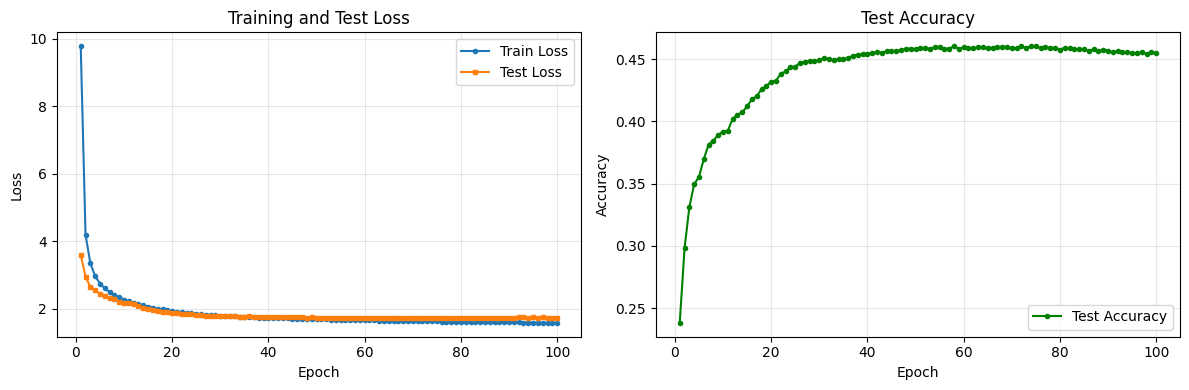

In [27]:
train_losses, test_losses, test_accs = train(model, transinput, test_input=test_transinput, epochs=epochs, lr=lr, batch_size=batch_size, padding_value=hiragana_map["padding"], save_path='best_model2.pth')

In [28]:
# 加载保存的模型
def load_model(model, load_path, device=None):
    """加载保存的模型权重"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load(load_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    
    # 移除 torch.compile 添加的 _orig_mod. 前缀
    if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
        state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model.to(device)
    
    print(f"模型已加载自: {load_path}")
    if 'epoch' in checkpoint:
        print(f"Epoch: {checkpoint['epoch']}")
    if 'test_loss' in checkpoint:
        print(f"Test Loss: {checkpoint['test_loss']:.4f}")
    if 'test_acc' in checkpoint:
        print(f"Test Acc: {checkpoint['test_acc']:.4f}")
    
    return model


model = TransformerModel(vocab_size=len(hiragana_map), embedding_dim=embedding_dim,dropout=dropout,num_heads=num_heads,layers=layers)
model = load_model(model, 'best_model2.pth')

模型已加载自: best_model2.pth
Epoch: 70
Test Loss: 1.7319
Test Acc: 0.4587


In [29]:
def generator(model, sex, prefix, max_length=20, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device
    if sex=="":
        test_in= [0] + [hiragana_map.get(c, 0) for c in [c for c in prefix]]
    else:
        test_in = [0] + [hiragana_map.get(c, 0) for c in [sex]+[c for c in prefix]]
    test_x = test_in.copy()
    with torch.no_grad():
        while len(test_x) < max_length:
            test_input = torch.tensor(test_x).unsqueeze(0).to(device)  # 添加批次维度，变为 (1, T)
            output = model(test_input)
            logits = output[0, -1, :]  # 获取最后一个时间步的输出
            logits = logits / temperature  # 根据温度调整 logits
            probabilities = F.softmax(logits, dim=-1)  # 转换为概率分布
            topk_values, topk_indices = torch.topk(probabilities, k=15)  # 获取前10个候选字符
            output_index = topk_indices[torch.multinomial(topk_values, num_samples=1).item()].item()
            if output_index == 0:  # 遇到结束标志
                break
            test_x.append(output_index)
    
    generated_name = ''.join(hiragana_index_map.get(idx, '') for idx in test_x[1:])  # 跳过开头的0
    return generated_name

In [47]:
sex="Male"#"Male"/"Female"/""
prefix="やまもと"  # 输入名字的前缀
generated_name = generator(model, sex, prefix, max_length=padding_length, temperature=0.5)
print(generated_name)

Maleやまもとけんじ


Using font: Microsoft YaHei


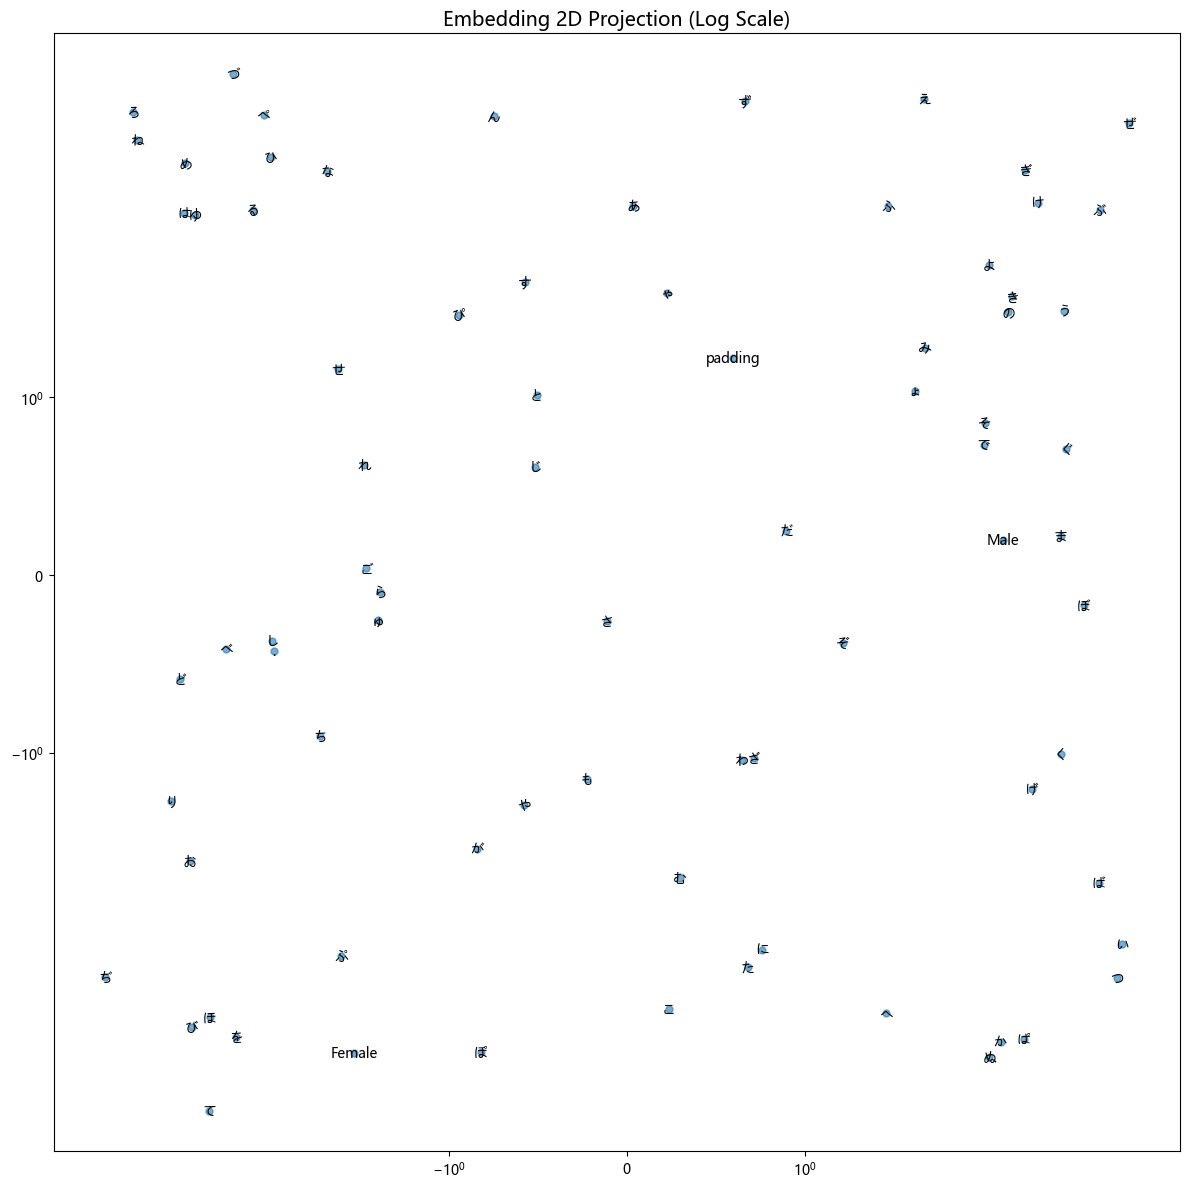

In [48]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 配置 matplotlib 支持日文字体 - 使用系统可用的字体
# Windows 常见字体
font_candidates = [
    'Microsoft YaHei',      # 微软雅黑
    'SimHei',               # 黑体
    'KaiTi',                # 楷体
    'ArialUnicodeMS',       # Arial Unicode MS
    'Yu Gothic',            # Yu Gothic (日文)
    'Hiragino Sans',        # Mac 日文
    'Noto Sans CJK JP',     # Linux 日文
]

# 检查哪个字体可用
available_font = None
for font_name in font_candidates:
    try:
        fm.findfont(font_name)
        available_font = font_name
        print(f"Using font: {available_font}")
        break
    except:
        continue

if available_font:
    plt.rcParams['font.sans-serif'] = [available_font]
else:
    print("Warning: No CJK font found, trying fallback...")
    plt.rcParams['font.sans-serif'] = plt.rcParams['font.sans-serif']  # 使用默认

plt.rcParams['axes.unicode_minus'] = False

# 取出 embedding 权重 (vocab_size, embedding_dim)
with torch.no_grad():
    emb_weight = model.embedding.weight.detach().cpu()

# 用 PCA 将 embedding 降到 2D
try:
    from sklearn.decomposition import PCA
    coords_2d = PCA(n_components=2).fit_transform(emb_weight.numpy())
except Exception:
    # fallback: 使用 torch 自带的 pca
    U, S, V = torch.pca_lowrank(emb_weight, q=2)
    coords_2d = (emb_weight @ V[:, :2]).numpy()

# 可视化：每个 token 一个点
fig, ax = plt.subplots(figsize=(12, 12))
# coords_2d = coords_2d[:6]  # 只可视化我们定义的 token
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], s=25, alpha=0.6)
for idx, (x, y) in enumerate(coords_2d):
    label = hiragana_index_map.get(idx, str(idx))
    # 只显示日文字符，跳过特殊标记
    #if isinstance(label, str) and label not in ['padding', 'Male', 'Female', '.']:
    ax.text(x, y, label, fontsize=10, ha='center', va='center')

ax.set_xscale('symlog')  # 对称对数刻度（可处理正负数）
ax.set_yscale('symlog')
ax.set_title("Embedding 2D Projection (Log Scale)", fontsize=14)
ax.axis("equal")
plt.tight_layout()
plt.show()

